In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

import os
import sys
# Set the current working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3')

from importlib import reload
from BrainAtlas.mouse.ac_create_scRNAseq_set_functions import *
reload(sys.modules['BrainAtlas.mouse.ac_create_scRNAseq_set_functions'])

<module 'BrainAtlas.mouse.ac_create_scRNAseq_set_functions' from '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3/BrainAtlas/mouse/ac_create_scRNAseq_set_functions.py'>

Processing WMB-10Xv3-HPF
Found 131297 cells in WMB-10Xv3-HPF
Processing WMB-10Xv3-TH
Found 130454 cells in WMB-10Xv3-TH
Processing WMB-10Xv3-P
Found 143157 cells in WMB-10Xv3-P
Processing WMB-10Xv3-MB
Found 337101 cells in WMB-10Xv3-MB
Processing WMB-10Xv2-HPF
Found 155033 cells in WMB-10Xv2-HPF
Processing WMB-10Xv2-TH
Found 130555 cells in WMB-10Xv2-TH
Processing WMB-10Xv2-MB
Found 29781 cells in WMB-10Xv2-MB
Processing WMB-10XMulti
Found 608 cells in WMB-10XMulti


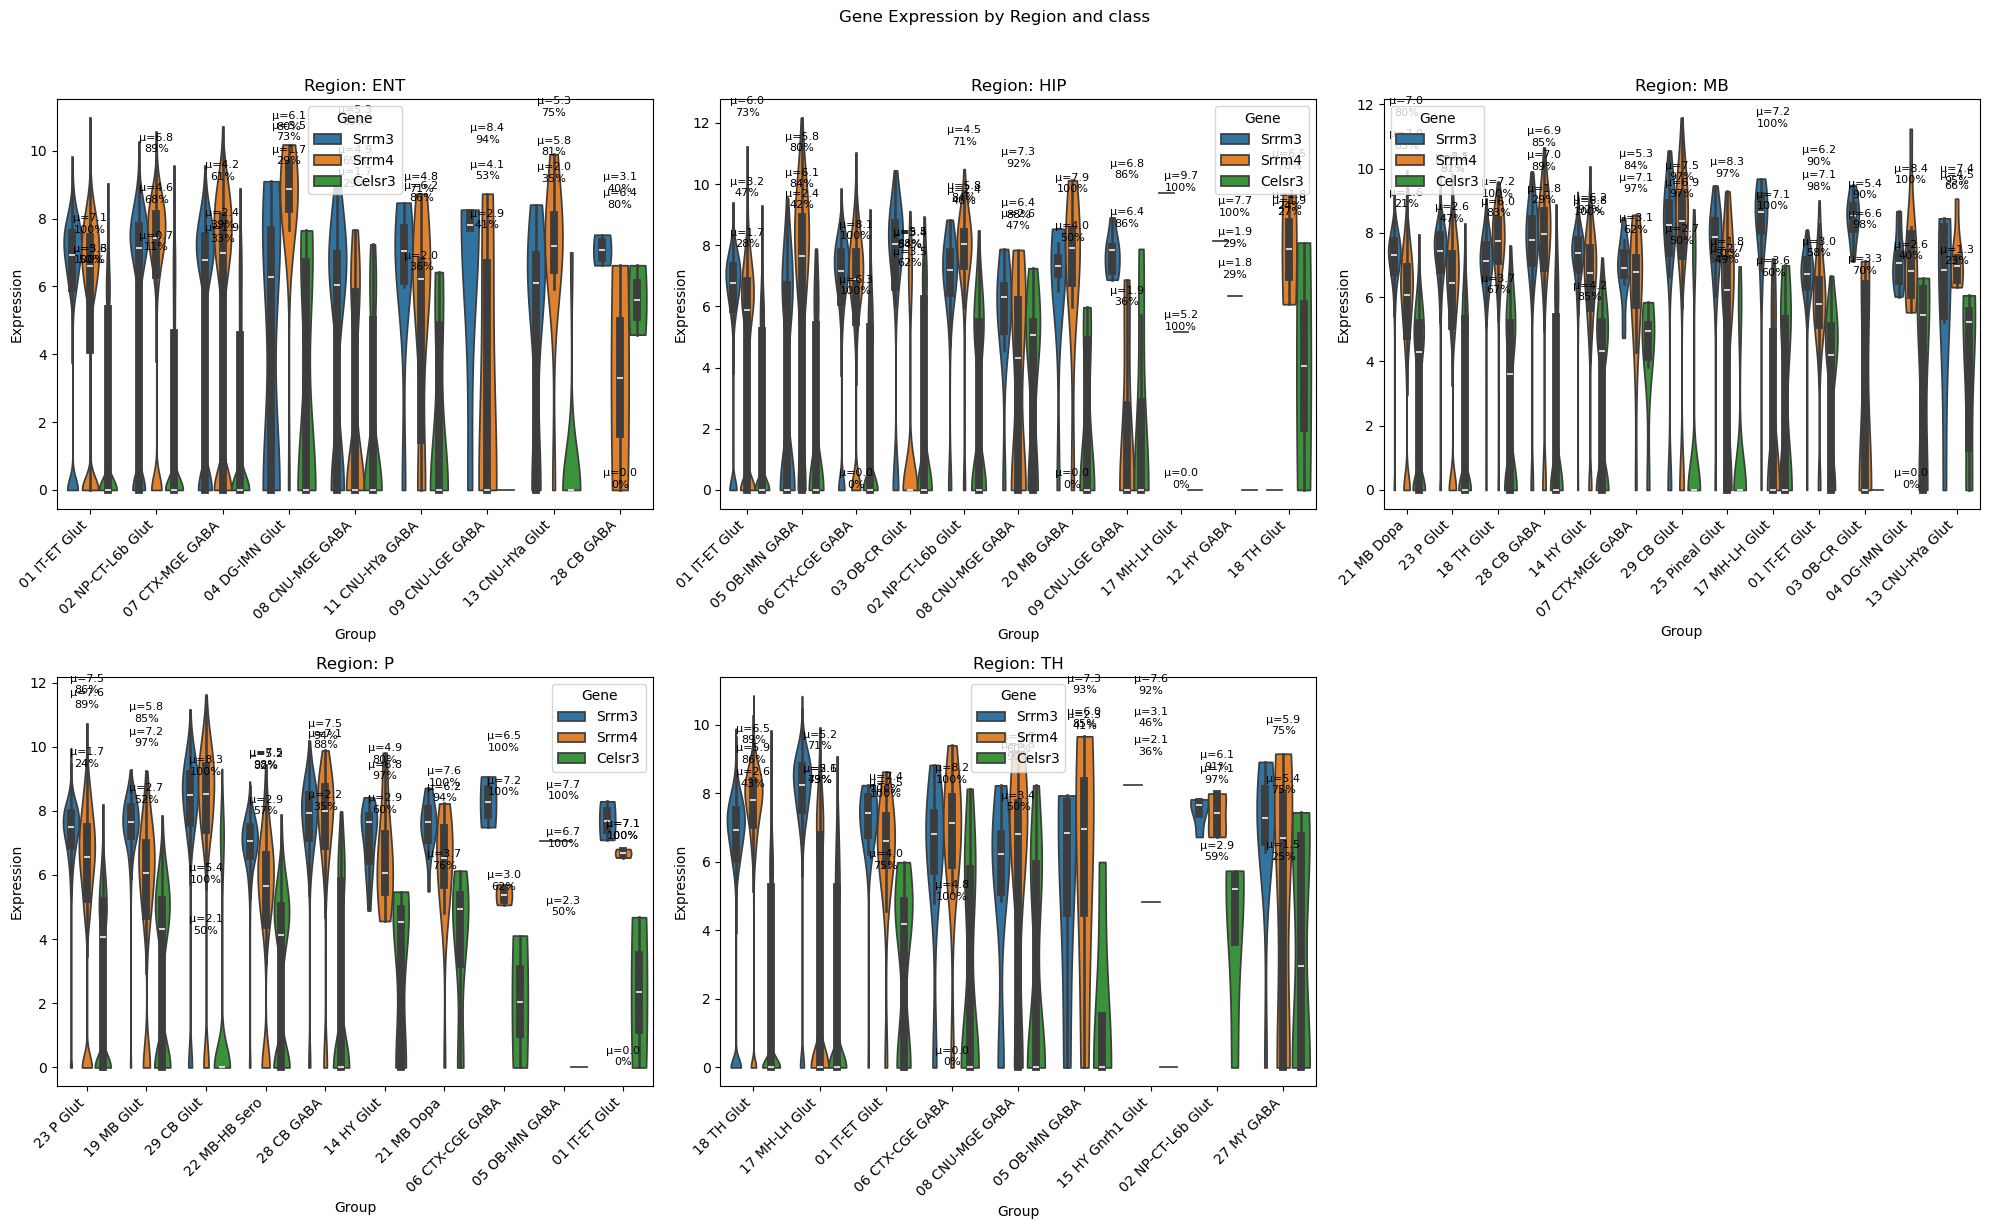

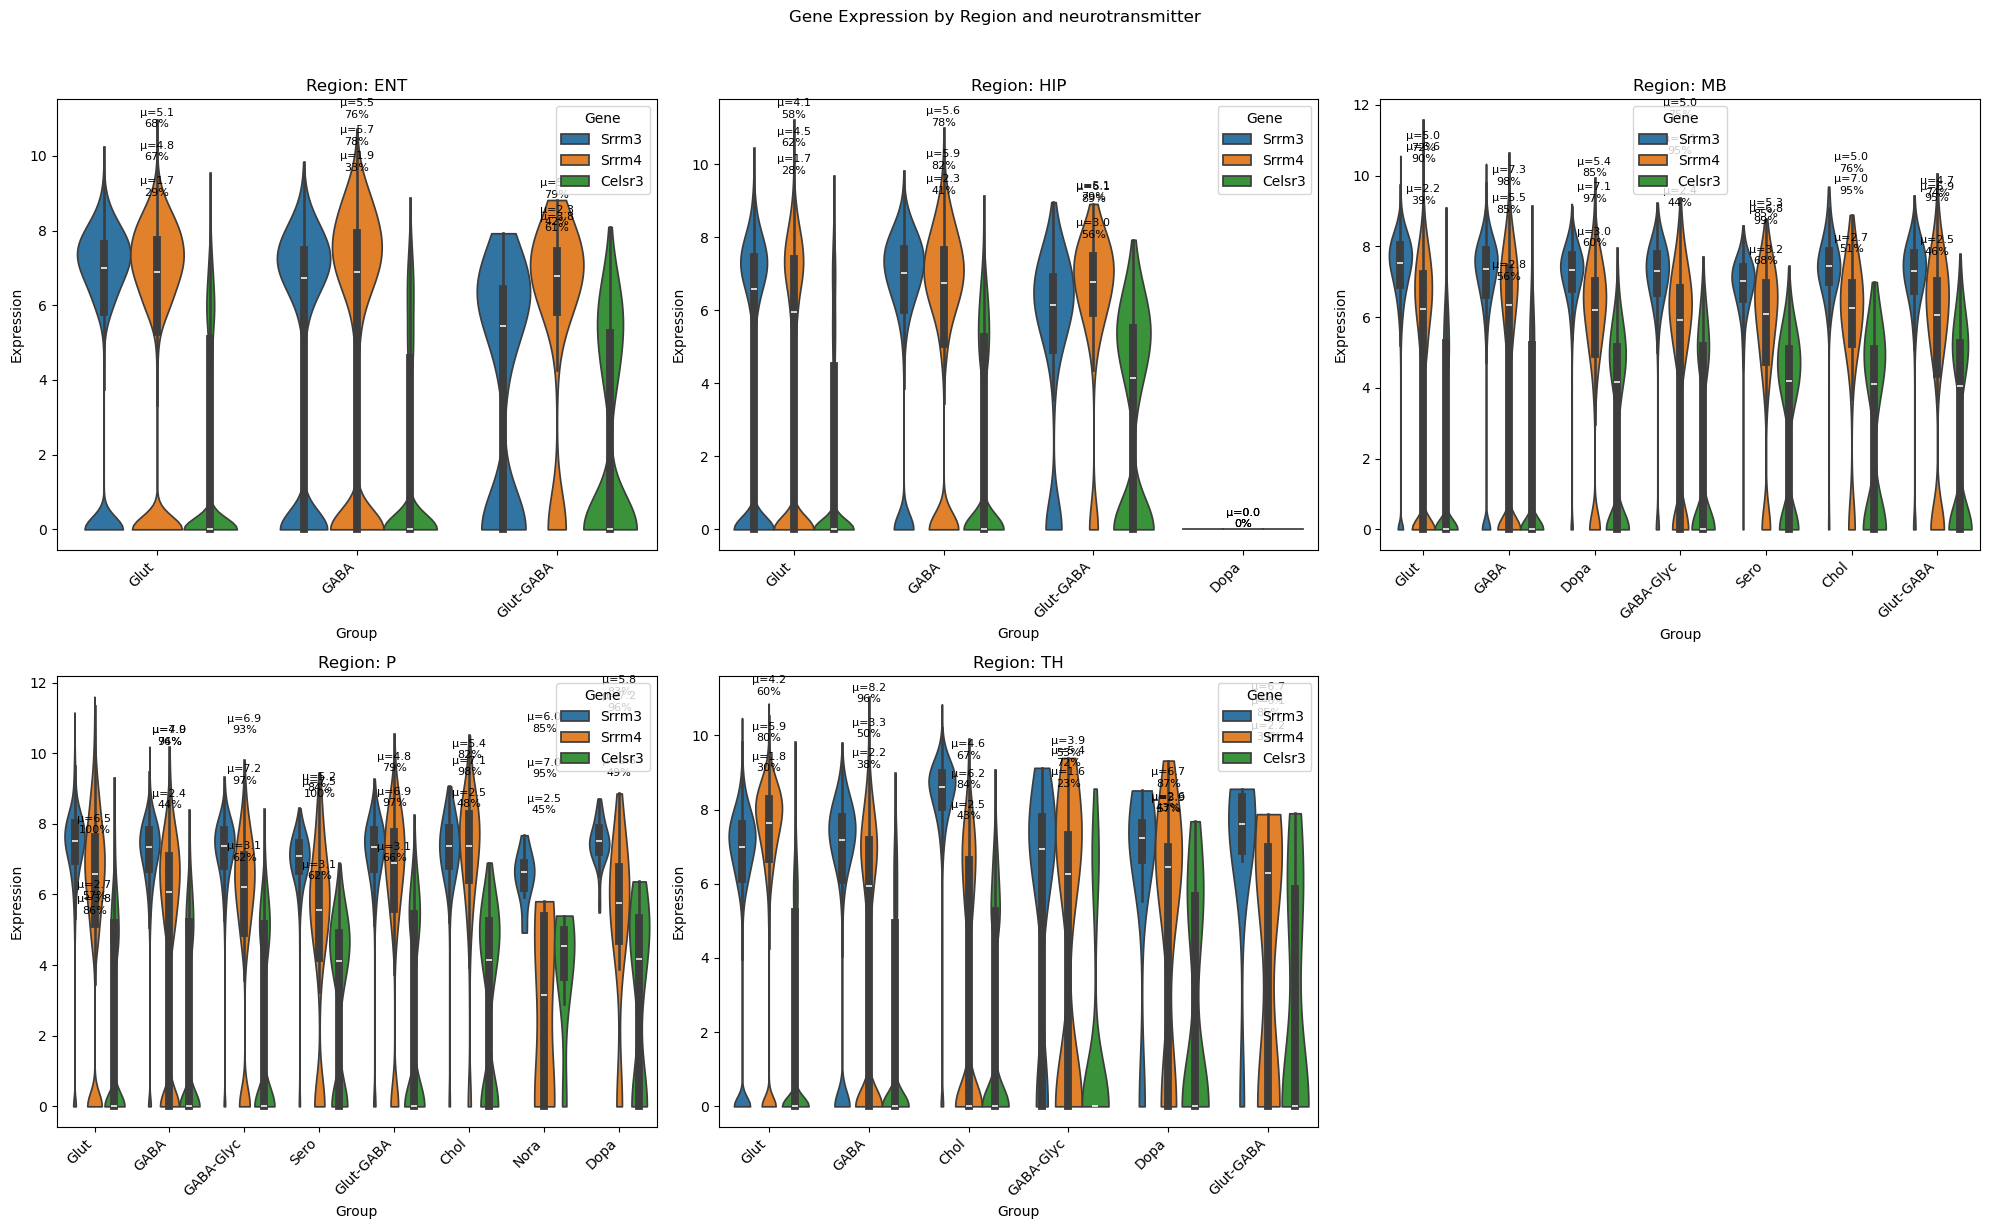

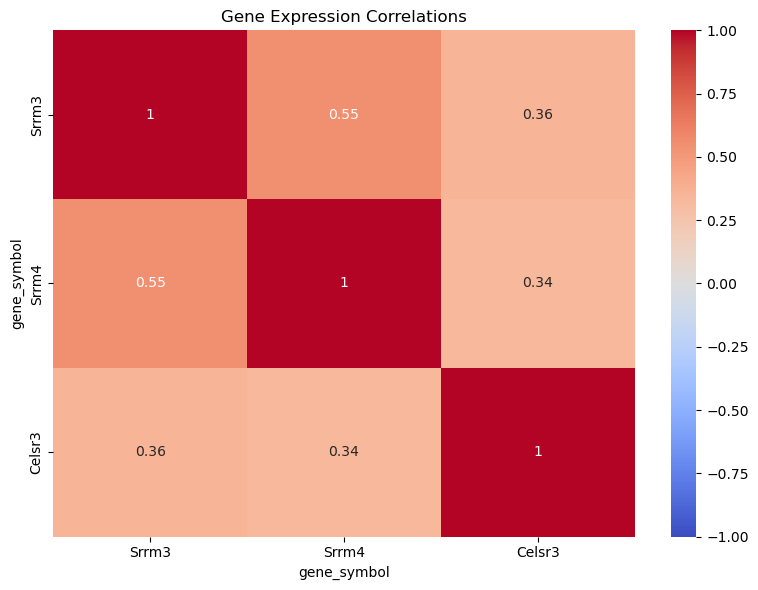


Summary Statistics by Region and Neurotransmitter:

Region: HIP

Dopa:
  Srrm3: mean=0.00, median=0.00, expressing=0.0%, n=1
  Srrm4: mean=0.00, median=0.00, expressing=0.0%, n=1
  Celsr3: mean=0.00, median=0.00, expressing=0.0%, n=1

GABA:
  Srrm3: mean=5.92, median=7.02, expressing=82.3%, n=15633
  Srrm4: mean=5.57, median=6.75, expressing=78.0%, n=15633
  Celsr3: mean=2.30, median=0.00, expressing=41.1%, n=15633

Glut:
  Srrm3: mean=4.47, median=6.58, expressing=61.5%, n=112234
  Srrm4: mean=4.13, median=5.96, expressing=57.8%, n=112234
  Celsr3: mean=1.69, median=0.00, expressing=27.7%, n=112234

Glut-GABA:
  Srrm3: mean=5.10, median=6.14, expressing=79.4%, n=428
  Srrm4: mean=6.11, median=6.79, expressing=88.6%, n=428
  Celsr3: mean=3.04, median=4.15, expressing=56.3%, n=428

Region: ENT

GABA:
  Srrm3: mean=4.84, median=6.74, expressing=67.1%, n=14973
  Srrm4: mean=5.11, median=6.89, expressing=67.9%, n=14973
  Celsr3: mean=1.70, median=0.00, expressing=29.0%, n=14973

Glut:
  S

In [132]:
# Initialize cache and load data
download_base = Path('./DATA/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

# Load metadata with cluster annotations
cell_metadata = abc_cache.get_metadata_dataframe(
    directory='WMB-10X', 
    file_name='cell_metadata_with_cluster_annotation'
)
cell_metadata.set_index('cell_label', inplace=True)

# Define genes and regions to analyze
genes = ['Srrm3', 'Srrm4', 'Celsr3']
regions = ['ENT', 'HIP', 'P', 'MB', 'TH', 'STR']

# Load expression data
expression_data, metadata = load_multi_region_data(
    cell_metadata=cell_metadata,
    abc_cache=abc_cache,
    datasets=['WMB-10X'],
    genes=genes,
    dataset_regions=regions
)

def plot_gene_expression_by_group(expression_data, metadata, group_by='class', min_expr_threshold=0.1):
    """Plot gene expression analysis by group"""
    
    # Prepare data
    plot_data = pd.DataFrame({
        'Expression': pd.concat([expression_data[gene] for gene in genes]),
        'Gene': np.repeat(genes, len(expression_data)),
        'Group': pd.concat([metadata[group_by] for _ in genes]),
        'Region': pd.concat([expression_data['region'] for _ in genes])
    })
    
    # Calculate statistics by group
    stats = []
    for region in plot_data['Region'].unique():
        region_data = plot_data[plot_data['Region'] == region]
        for group in region_data['Group'].unique():
            for gene in genes:
                group_gene_data = region_data[
                    (region_data['Group'] == group) & 
                    (region_data['Gene'] == gene)
                ]
                
                if len(group_gene_data) > 0:
                    stats.append({
                        'Region': region,
                        'Group': group,
                        'Gene': gene,
                        'Mean': group_gene_data['Expression'].mean(),
                        'Median': group_gene_data['Expression'].median(),
                        'Std': group_gene_data['Expression'].std(),
                        'Pct_expressing': (group_gene_data['Expression'] > min_expr_threshold).mean() * 100,
                        'N_cells': len(group_gene_data)
                    })
    
    stats_df = pd.DataFrame(stats)
    
    # Plot violin plots by region
    regions = sorted(plot_data['Region'].unique())
    n_regions = len(regions)
    fig, axes = plt.subplots(2, (n_regions+1)//2, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, region in enumerate(regions):
        region_stats = stats_df[stats_df['Region'] == region]
        
        # Get top groups by mean expression
        top_groups = []
        for gene in genes:
            gene_stats = region_stats[region_stats['Gene'] == gene]
            top = gene_stats.nlargest(5, 'Mean')['Group'].tolist()
            top_groups.extend(top)
        top_groups = list(set(top_groups))
        
        region_data = plot_data[plot_data['Region'] == region]
        region_data = region_data[region_data['Group'].isin(top_groups)]
        
        sns.violinplot(data=region_data,
                      x='Group',
                      y='Expression',
                      hue='Gene',
                      ax=axes[idx],
                      cut=0,
                      scale='width',
                      inner='box')
        
        axes[idx].set_title(f'Region: {region}')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
        
        # Add statistics
        for i, group in enumerate(top_groups):
            for j, gene in enumerate(genes):
                stats_row = region_stats[
                    (region_stats['Group'] == group) & 
                    (region_stats['Gene'] == gene)
                ]
                if not stats_row.empty:
                    stats_row = stats_row.iloc[0]
                    y_pos = region_data[
                        (region_data['Group'] == group) & 
                        (region_data['Gene'] == gene)
                    ]['Expression'].max()
                    if not pd.isna(y_pos):
                        axes[idx].text(i, y_pos,
                                     f'μ={stats_row["Mean"]:.1f}\n{stats_row["Pct_expressing"]:.0f}%',
                                     ha='center', va='bottom', fontsize=8)
    
    # Remove empty subplots
    for idx in range(n_regions, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle(f'Gene Expression by Region and {group_by}', y=1.02)
    plt.tight_layout()
    return fig, axes, stats_df

# Plot by class
fig, axes, class_stats = plot_gene_expression_by_group(expression_data, metadata, 'class')
plt.show()

# Plot by neurotransmitter
fig, axes, nt_stats = plot_gene_expression_by_group(expression_data, metadata, 'neurotransmitter')
plt.show()

# Create correlation heatmap
plt.figure(figsize=(8, 6))
corr_matrix = expression_data[genes].corr()
sns.heatmap(corr_matrix, 
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0)
plt.title('Gene Expression Correlations')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics by Region and Neurotransmitter:")
for region in nt_stats['Region'].unique():
    print(f"\nRegion: {region}")
    region_stats = nt_stats[nt_stats['Region'] == region]
    for nt in sorted(region_stats['Group'].unique()):
        print(f"\n{nt}:")
        for gene in genes:
            gene_stats = region_stats[
                (region_stats['Group'] == nt) & 
                (region_stats['Gene'] == gene)
            ]
            if not gene_stats.empty:
                stats = gene_stats.iloc[0]
                print(f"  {gene}: mean={stats['Mean']:.2f}, median={stats['Median']:.2f}, "
                      f"expressing={stats['Pct_expressing']:.1f}%, n={stats['N_cells']}")